# Towards Cellular-Level Alignment: A Coarse-to-Fine Approach for Multistain Whole Slide Image Registration

This notebook demonstrates the complete workflow for Whole Slide Image (WSI) registration using rigid and non-rigid techniques with nuclei-based analysis.

## Overview
- **Coarse Registration**: Initial coarse alignment using traditional techniques

## 1. Setup and Imports

In [1]:
import sys
import os

# Add project root to PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # adjust if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [3]:
# Enable inline plotting and auto-reload for development
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import all necessary modules
import SimpleITK as sitk 
from core.utils.imports import *
from core.config import *
from core.preprocessing.preprocessing import *
from core.preprocessing.padding import *
from core.registration.registration import *
from core.registration.nonrigid import *
from core.evaluation.evaluation import *
from core.visualization.visualization import *
from core.preprocessing.nuclei_analysis import *

# Setup Bokeh for notebook output
setup_bokeh_notebook()

print("✅ All modules imported successfully!")
print(f"Source WSI: {SOURCE_WSI_PATH}")
print(f"Target WSI: {TARGET_WSI_PATH}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


|2025-11-16|12:40:22.683| [WARNING] /home/u5552013/miniconda3/envs/tiatoolbox-reg-vis/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



Loading BokehJS ...

✅ All modules imported successfully!
Source WSI: /home/u5552013/Nextcloud/REACTIVAS_vis/1/slides/1.svs
Target WSI: /home/u5552013/Nextcloud/REACTIVAS_vis/1/slides/1_ome.tiff


## 2. Configuration Check

Verify that all file paths are correct and files exist.

## 3. Load and Preprocess WSI Images

In [4]:
import os

# Check if files exist
files_to_check = [
    SOURCE_WSI_PATH,
    TARGET_WSI_PATH,
    FIXED_POINTS_PATH,
    MOVING_POINTS_PATH
]

print("File existence check:")
for file_path in files_to_check:
    exists = os.path.exists(file_path)
    status = "✅" if exists else "❌"
    print(f"{status} {file_path}")

# Display current parameters
print("\nCurrent Parameters:")
print(f"- Preprocessing Resolution: {PREPROCESSING_RESOLUTION}")
print(f"- Registration Resolution: {REGISTRATION_RESOLUTION}")
print(f"- Patch Size: {PATCH_SIZE}")
print(f"- Fixed Threshold: {FIXED_THRESHOLD}")
print(f"- Moving Threshold: {MOVING_THRESHOLD}")
print(f"- Min Nuclei Area: {MIN_NUCLEI_AREA}")

File existence check:
✅ /home/u5552013/Nextcloud/REACTIVAS_vis/1/slides/1.svs
✅ /home/u5552013/Nextcloud/REACTIVAS_vis/1/slides/1_ome.tiff
❌ /home/u5552013/Nextcloud/HYRECO/Eval/he_533.csv
❌ /home/u5552013/Nextcloud/HYRECO/Eval/ki67_533.csv

Current Parameters:
- Preprocessing Resolution: 0.625
- Registration Resolution: 40
- Patch Size: (1000, 1000)
- Fixed Threshold: 100
- Moving Threshold: 50
- Min Nuclei Area: 200


In [5]:
# Load WSI images
print("Loading WSI images...")
source_wsi, target_wsi, source, target = load_wsi_images(
    SOURCE_WSI_PATH, TARGET_WSI_PATH, PREPROCESSING_RESOLUTION
)

print(f"\nLoaded images:")
print(f"Source shape: {source.shape}")
print(f"Target shape: {target.shape}")

|2025-11-16|12:40:31.536| [ERROR] File does not have a .json extension.
|2025-11-16|12:40:31.544| [ERROR] File does not have a .json extension.
|2025-11-16|12:40:31.546| [ERROR] File does not have a .json extension.


|2025-11-16|12:40:31.616| [ERROR] File does not have a .json extension.
|2025-11-16|12:40:31.618| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


Loading WSI images...
Source original shape: (816, 685, 3)
Target original shape: (698, 698, 3)

Loaded images:
Source shape: (816, 685, 3)
Target shape: (698, 698, 3)


In [7]:
from skimage.segmentation import find_boundaries
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import rescale_intensity, equalize_adapthist, adjust_gamma
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, remove_small_holes, disk, dilation, erosion, disk
from skimage.filters import threshold_otsu, median
from skimage.measure import label, regionprops
from skimage import color, exposure, filters, morphology

In [8]:
import matplotlib.cm as cm
# Preprocess images
print("Preprocessing images...")
source_prep,target_prep, padding_params=pad_images(source, target)
# Extract tissue masks
print("Extracting tissue masks...")
source_mask, target_mask = extract_tissue_masks(source_prep, target_prep, artefacts=False)
# source_mask=tissue_masking(source_prep)
# target_mask=tissue_masking(target_prep)
print("✅ Preprocessing completed!")

Preprocessing images...
Extracting tissue masks...
✅ Preprocessing completed!


## 4. Visualize Original Images and Tissue Masks

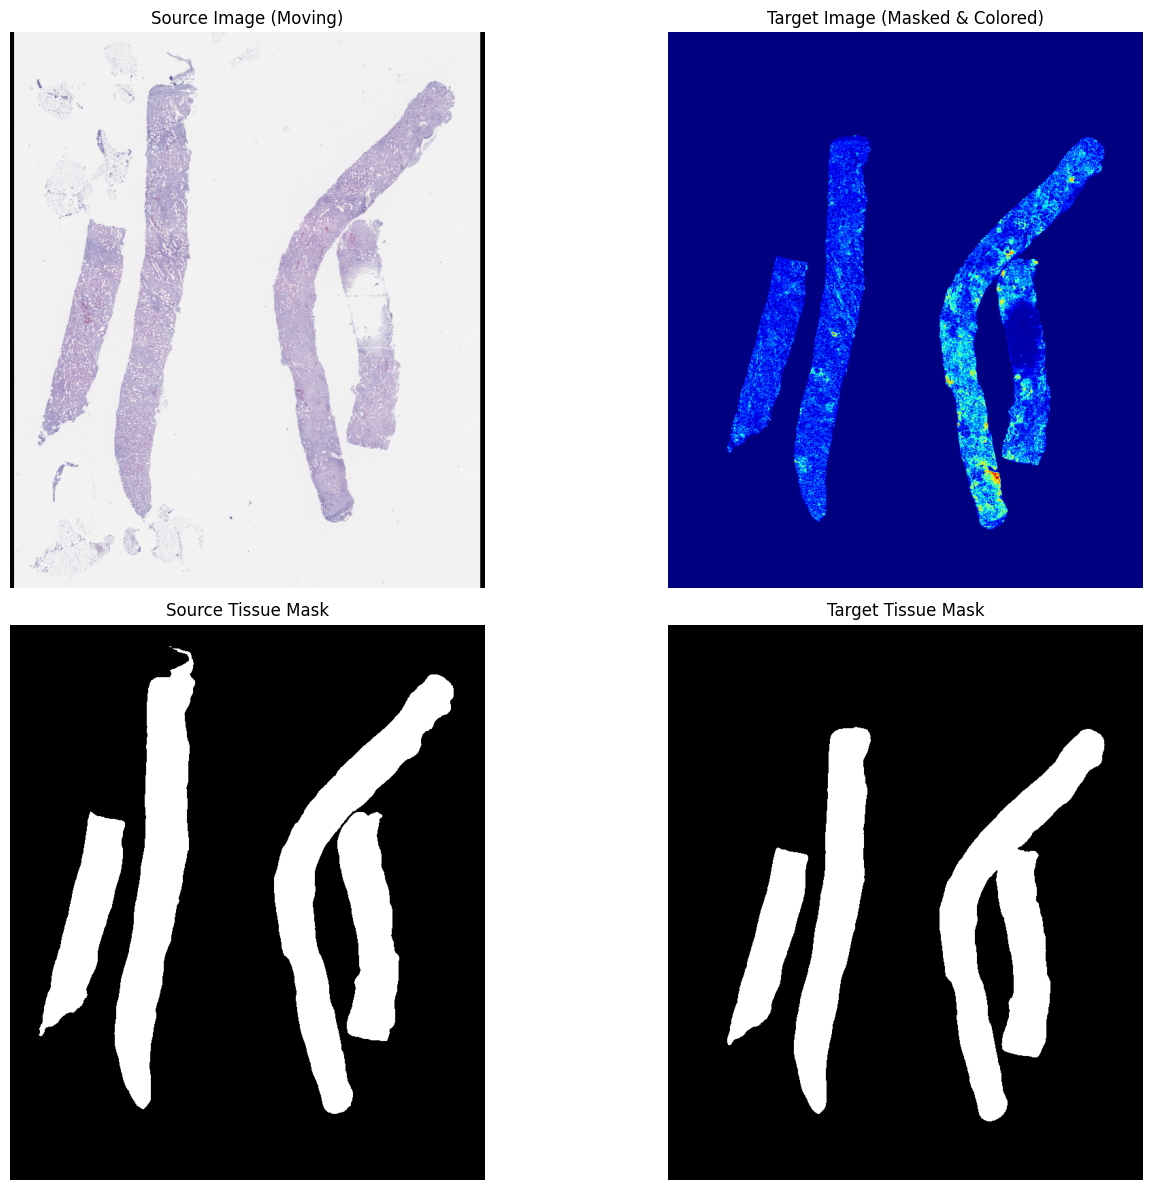

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Create a blank RGB image
colored = np.zeros((*target_prep.shape, 3), dtype=np.uint8)

# Apply colormap only on the masked region
masked_region = target_prep.copy()
masked_region[target_mask == 0] = 0  # zero out regions outside the mask

colored_masked = cv2.applyColorMap(masked_region, cv2.COLORMAP_JET)
colored_masked = cv2.cvtColor(colored_masked, cv2.COLOR_BGR2RGB)

# Display side by side
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(source_prep)
axes[0, 0].set_title('Source Image (Moving)')
axes[0, 0].axis('off')

axes[0, 1].imshow(colored_masked)
axes[0, 1].set_title('Target Image (Masked & Colored)')
axes[0, 1].axis('off')

axes[1, 0].imshow(source_mask, cmap='gray')
axes[1, 0].set_title('Source Tissue Mask')
axes[1, 0].axis('off')

axes[1, 1].imshow(target_mask, cmap='gray')
axes[1, 1].set_title('Target Tissue Mask')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


## 5. Perform Rigid Registration

|2025-11-16|12:41:19.809| [WARNING] /home/u5552013/Desktop/CORE/accelerated_features/modules/xfeat.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_d

Performing rigid registration...
loading weights from: /home/u5552013/Desktop/CORE/accelerated_features/modules/../weights/xfeat.pt
NGF metric: 0.027988555719914363
NGF metric: 0.006490402658461951
loading weights from: /home/u5552013/Desktop/CORE/accelerated_features/modules/../weights/xfeat.pt
NGF metric: 0.008033502965894305
NGF metric: 0.01484758285238743

Rigid transformation matrix:
[[ 1.          0.         20.03930705]
 [ 0.          1.         41.37011612]
 [ 0.          0.          1.        ]]
(816, 698, 3)


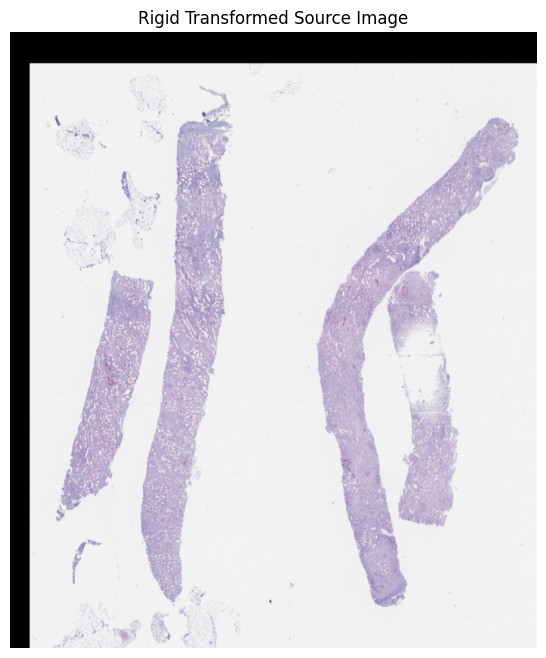

✅ Rigid registration completed!


In [10]:
# Perform rigid registration
from accelerated_features.modules.xfeat import XFeat
print("Performing rigid registration...")
aligner = rigid.XFeatReg()
best_transform1, moving_img_transformed = aligner.register(target_prep,source_prep)
moving_img_transformed, final_transform = perform_rigid_registration(
    source_prep, target_prep, source_mask, target_mask
)

print("\nRigid transformation matrix:")
print(final_transform)
print(moving_img_transformed.shape)
# Visualize transformed image
plt.figure(figsize=(12, 8))
plt.imshow(moving_img_transformed)
plt.title('Rigid Transformed Source Image')
plt.axis('off')
plt.show()

print("✅ Rigid registration completed!")

In [11]:
u_x, u_y = util.rigid_dot(source_prep,np.linalg.inv(final_transform))
deformation_field = np.stack(( u_x, u_y), axis=-1)
sitk_image = sitk.GetImageFromArray(deformation_field)
# sitk.WriteImage(sitk_image, './anhir_rigid.mha')

In [40]:

import skimage.io as sio
import plotly.express as px
# warped2=tensor_to_rgb_numpy(warped_source)
# # warped1=color.gray2rgb(warped)

imgbg= colored_masked
figbg=px.imshow(imgbg, width=500, height=500)
figbg.update_layout(xaxis_visible=False, yaxis_visible=False)
# figbg.show()

imgfg=warped1
figfg=px.imshow(imgfg, width=500, height=500)
figfg.update_layout(xaxis_visible=False, yaxis_visible=False)
alphabg= 0.3 # the parameter for the background image
alphafg = 0.8  # parameter for the foreground image 

#convex combination of the arrays representing the two images
blendarray = (alphabg * imgbg + alphafg*(1-alphabg)* imgfg)/(alphabg+alphafg*(1-alphabg))

blendimg=px.imshow(blendarray)
blendimg.update_layout(xaxis_visible=False, yaxis_visible=False)

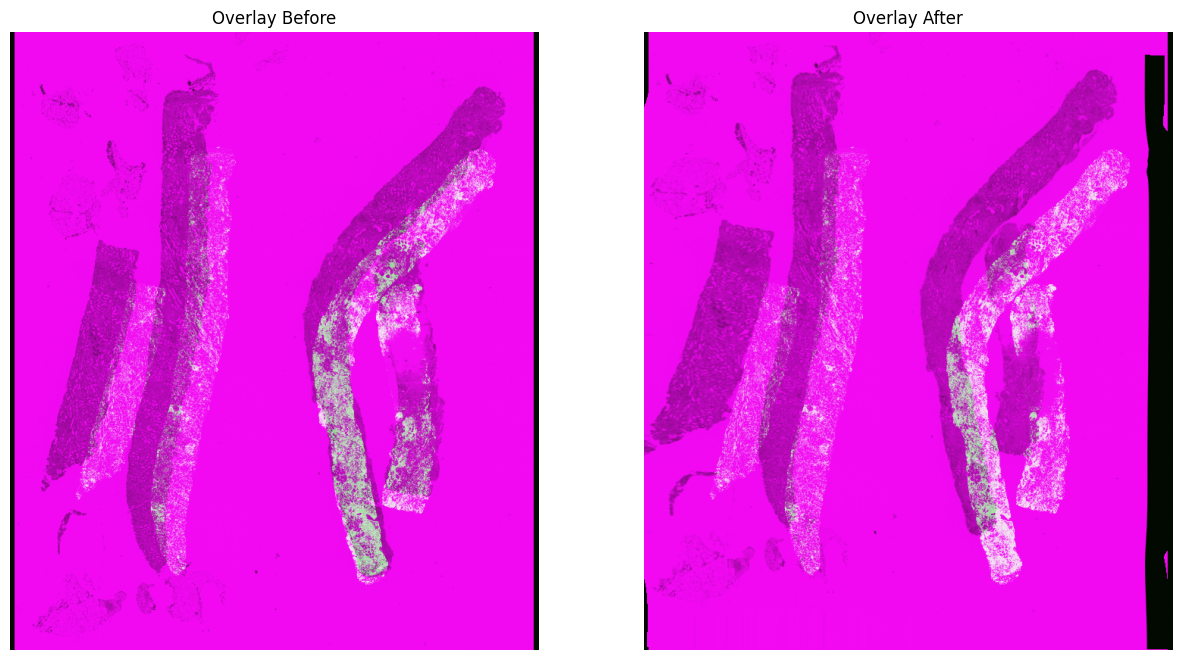

In [22]:

visualize_overlays(colored_masked,source_prep,warped)

## 6. Non Rigid Registration

In [12]:
displacement_field,warped_source= elastic_image_registration(
   moving_img_transformed,
   target_prep,
    similarity_metric_params={'win_size': 7}, 
     compute_device='cuda'  # Use the same device
)
print("non rigid displacement field",displacement_field.shape)

|2025-11-16|12:42:08.953| [WARNING] /home/u5552013/Desktop/CORE/core/registration/nonrigid.py:741: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_tensor = t.tensor(tensor_source, dtype=t.float32, requires_grad=True).to(compute_device)

|2025-11-16|12:42:08.953| [WARNING] /home/u5552013/Desktop/CORE/core/registration/nonrigid.py:742: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = t.tensor(tensor_target, dtype=t.float32, requires_grad=True).to(compute_device)



non rigid displacement field torch.Size([1, 816, 698, 2])


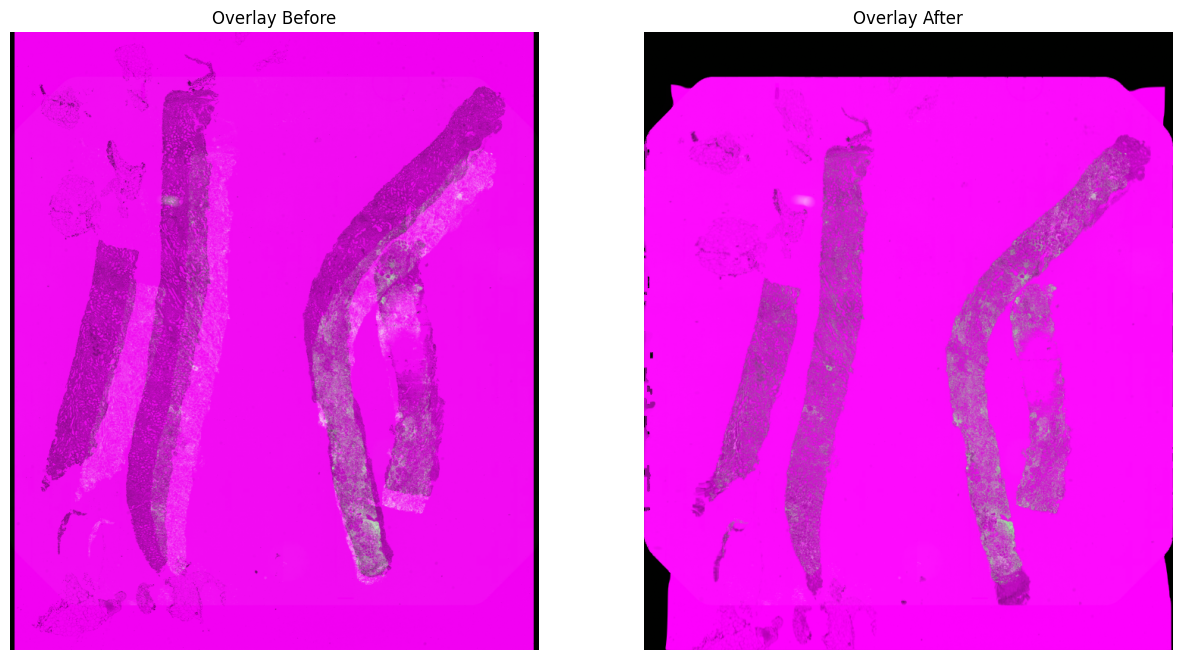

In [19]:

def tensor_to_rgb_numpy(tensor):
    # (1, 1, H, W) -> (3, H, W) -> (H, W, 3)
    tensor_rgb = tensor.squeeze().repeat(3, 1, 1)
    return tensor_rgb.permute(1, 2, 0).detach().cpu().numpy()

visualize_overlays(target_prep, source_prep,     tensor_to_rgb_numpy(warped_source))

In [ ]:
u_x, u_y = util.rigid_dot(source_prep,final_transform)
disp_field_np = util.tc_df_to_np_df(displacement_field)
w_x,w_y=util.compose_vector_fields(u_x, u_y, disp_field_np[0], disp_field_np[1])
deformation_field = np.stack(( w_x, w_y), axis=-1)
sitk_image = sitk.GetImageFromArray(deformation_field)
sitk.WriteImage(sitk_image, './mif.mha')

u_x shape:  (816, 698)


## 7. Visualization

In [ ]:
%%bash 
tiatoolbox visualize --slides "/home/u5552013/Nextcloud/HYRECO_VIS/slides" --overlays "/home/u5552013/Nextcloud/HYRECO_VIS/overlays"


## 8. Scale Transformation and Extract Patches

In [ ]:

rigid_matrix_corrected = final_transform.copy()
transform_40x = scale_transformation_matrix(
    rigid_matrix_corrected, PREPROCESSING_RESOLUTION,10
)


# Extract patches from target WSI
print("\nExtracting patches...")
fixed_patch_extractor = extract_patches_from_wsi(
    target_wsi, target_mask, PATCH_SIZE, PATCH_STRIDE
)

print(f"Total patches extracted: {len(fixed_patch_extractor)}")

|2025-11-16|01:44:55.062| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


Corrected rigid matrix:
 [[ 9.07134066e-01 -9.33487952e-03  4.02677180e+01]
 [ 9.33487952e-03  9.07134066e-01  1.04082581e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Scaled transformation matrix (40x):
[[ 9.07134066e-01 -9.33487952e-03  6.44283487e+02]
 [ 9.33487952e-03  9.07134066e-01  1.66532130e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Extracting patches...
Total patches extracted: 433


## 7. Visualize Sample Patches

In [ ]:
rigid_matrix_corrected = final_transform.copy()
print("Corrected rigid matrix:\n", rigid_matrix_corrected)
transform_40x = scale_transformation_matrix(
    rigid_matrix_corrected, PREPROCESSING_RESOLUTION,40
)
# REGISTRATION_RESOLUTION
print("Scaled transformation matrix (40x):")
print(transform_40x)

# Extract patches from target WSI
print("\nExtracting patches...")
fixed_patch_extractor = extract_patches_from_wsi(
    target_wsi, target_mask, PATCH_SIZE, PATCH_STRIDE
)

print(f"Total patches extracted: {len(fixed_patch_extractor)}")

Corrected rigid matrix:
 [[ 1.          0.         20.03930705]
 [ 0.          1.         41.37011612]
 [ 0.          0.          1.        ]]
Scaled transformation matrix (40x):
[[1.00000000e+00 0.00000000e+00 1.28251565e+03]
 [0.00000000e+00 1.00000000e+00 2.64768743e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Extracting patches...
Total patches extracted: 445


Visualizing patch 50 at location (32500, 13500)


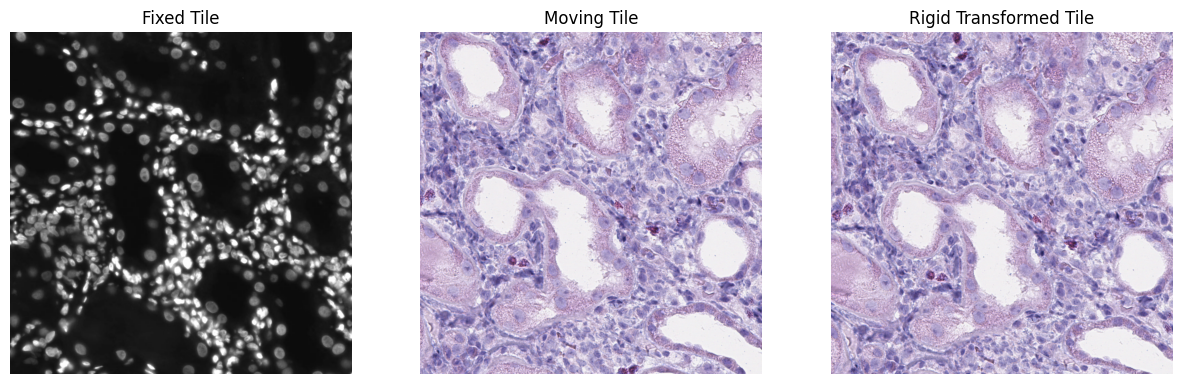

In [ ]:
# Select a patch for visualization
patch_idx = 50# You can change this index
loc = fixed_patch_extractor.coordinate_list[patch_idx]
location = (loc[0], loc[1])

print(f"Visualizing patch {patch_idx} at location {location}")

fixed_tile = target_wsi.read_rect(location, VISUALIZATION_SIZE, resolution=40, units="power")
moving_tile = source_wsi.read_rect(location, VISUALIZATION_SIZE, resolution=40, units="power")
tfm = AffineWSITransformer(source_wsi, final_transform)
transformed_tile = tfm.read_rect(location=location, size=VISUALIZATION_SIZE, resolution=40, units="power")
visualize_patches(fixed_tile, moving_tile, transformed_tile)

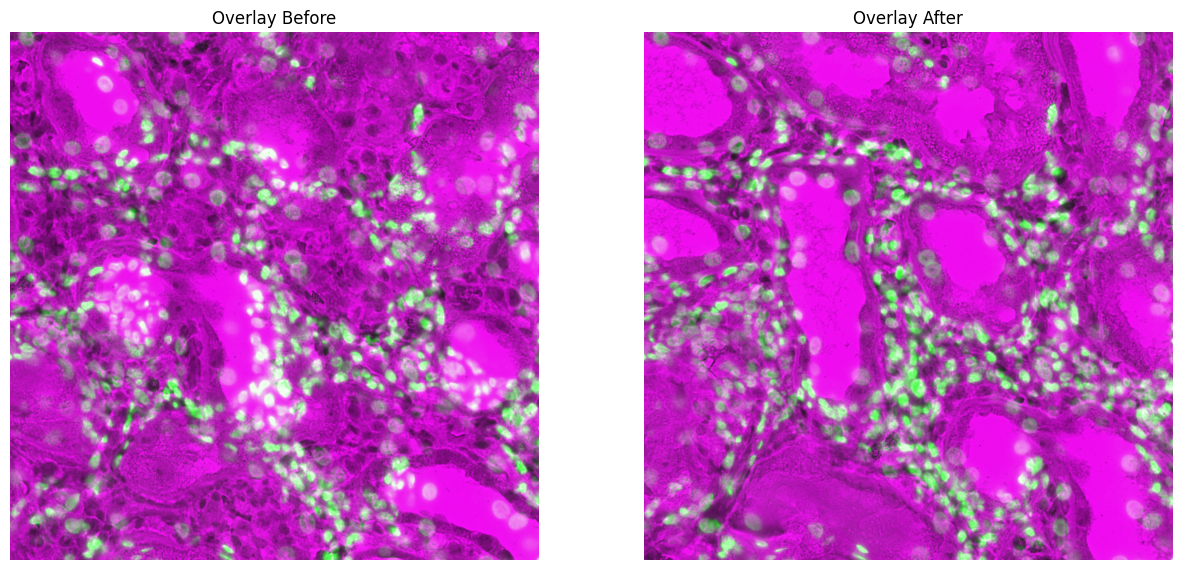

In [202]:
visualize_overlays( fixed_tile,moving_tile,transformed_tile)

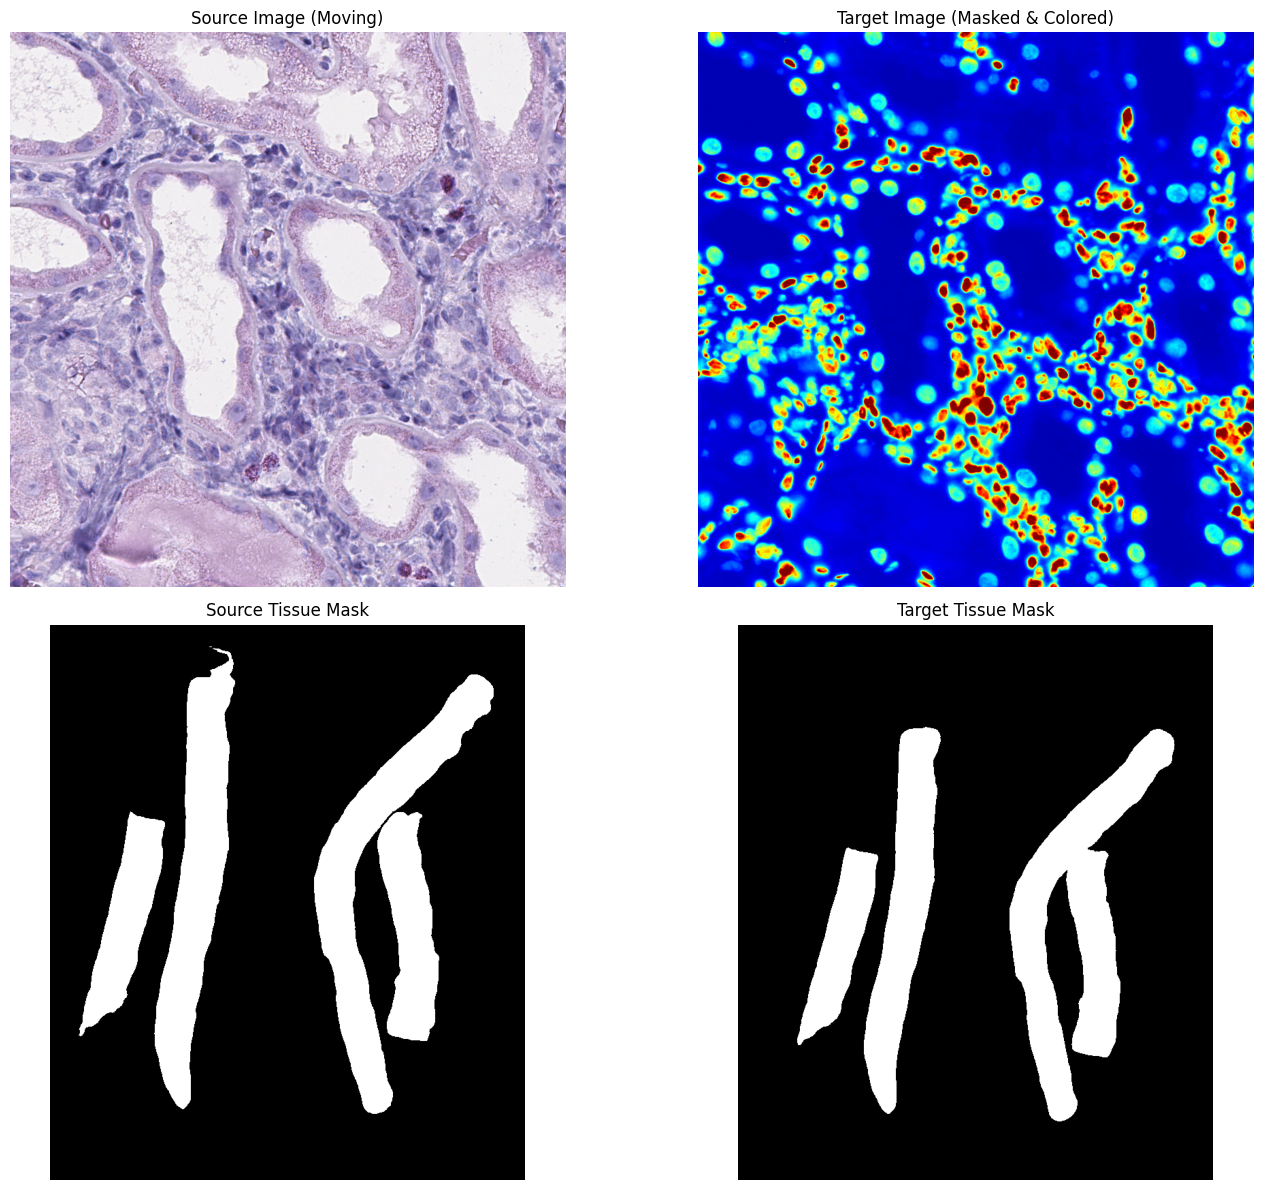

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Create a blank RGB image
colored = np.zeros((*fixed_tile.shape, 3), dtype=np.uint8)

# Apply colormap only on the masked region
masked_region = fixed_tile.copy()
# masked_region[target_mask == 0] = 0  # zero out regions outside the mask

colored_masked = cv2.applyColorMap(masked_region, cv2.COLORMAP_JET)
colored_masked = cv2.cvtColor(colored_masked, cv2.COLOR_BGR2RGB)

# Display side by side
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].imshow(mov_tile)
axes[0, 0].set_title('Source Image (Moving)')
axes[0, 0].axis('off')

axes[0, 1].imshow(colored_masked)
axes[0, 1].set_title('Target Image (Masked & Colored)')
axes[0, 1].axis('off')

axes[1, 0].imshow(source_mask, cmap='gray')
axes[1, 0].set_title('Source Tissue Mask')
axes[1, 0].axis('off')

axes[1, 1].imshow(target_mask, cmap='gray')
axes[1, 1].set_title('Target Tissue Mask')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
